In [2]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image

In [3]:
samples = 20000
df = pd.read_csv("train.csv")
df = df.loc[:samples,:]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

In [4]:
df.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [5]:
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)

Size of training data: (20001, 2)
Number of unique classes: 1020


In [6]:
data = pd.DataFrame(df['landmark_id'].value_counts())
#index the data frame
data.reset_index(inplace=True) 
data.columns=['landmark_id','count']

print(data.head(10))
print(data.tail(10))

   landmark_id  count
0         1924    944
1           27    504
2          454    254
3         1346    244
4         1127    201
5          870    193
6         2185    177
7         1101    162
8          389    140
9          219    139
      landmark_id  count
1010         1548      2
1011         1234      2
1012         2118      2
1013         1644      2
1014         1838      2
1015         1449      2
1016         2297      2
1017         1662      2
1018          289      2
1019          215      2


count    1020.000000
mean       19.608824
std        41.653684
min         2.000000
25%         5.000000
50%         9.000000
75%        21.000000
max       944.000000
Name: count, dtype: float64


Text(0, 0.5, 'Occurences')

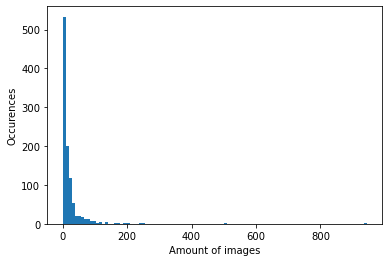

In [7]:
print(data['count'].describe())#statistical data for the distribution
plt.hist(data['count'],100,range = (0,944),label = 'test')#Histogram of the distribution
plt.xlabel("Amount of images")
plt.ylabel("Occurences")

Amount of classes with five and less datapoints: 322
Amount of classes with with between five and 10 datapoints: 342


Text(0, 0.5, 'Number of images')

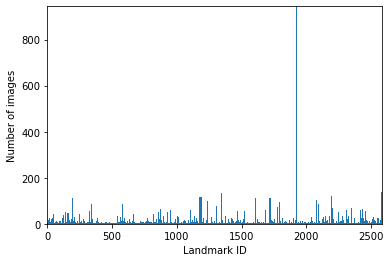

In [8]:
print("Amount of classes with five and less datapoints:", (data['count'].between(0,5)).sum()) 

print("Amount of classes with with between five and 10 datapoints:", (data['count'].between(5,10)).sum())

n = plt.hist(df["landmark_id"],bins=df["landmark_id"].unique())
freq_info = n[0]

plt.xlim(0,data['landmark_id'].max())
plt.ylim(0,data['count'].max())
plt.xlabel('Landmark ID')
plt.ylabel('Number of images')

In [9]:
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

def encode_label(lbl):
    return lencoder.transform(lbl)
    
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)
    
def get_image_from_number(num):
    fname, label = df.loc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label

print("4 sample images from random classes:")
fig=plt.figure(figsize=(16, 16))
for i in range(1,5):
    a = random.choices(os.listdir(base_path), k=3)
    folder = base_path+'/'+a[0]+'/'+a[1]+'/'+a[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

4 sample images from random classes:


NameError: name 'base_path' is not defined

<Figure size 1152x1152 with 0 Axes>

In [10]:
from keras.applications import VGG19
from keras.layers import *
from keras import Sequential

### Parameters
# learning_rate   = 0.0001
# decay_speed     = 1e-6
# momentum        = 0.09

# loss_function   = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
#new_layer = Dense(num_classes, activation=activations.softmax, name='prediction')
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)


model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
#     if layer == source_model.layers[-3]:
#         model.add(drop_layer)
# model.add(drop_layer2)
model.add(Dense(num_classes, activation="softmax"))
model.summary()


opt1 = keras.optimizers.RMSprop(learning_rate = 0.0001, momentum = 0.09)
opt2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=opt1,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

#sgd = SGD(lr=learning_rate, decay=decay_speed, momentum=momentum, nesterov=True)
# rms = keras.optimizers.RMSprop(lr=learning_rate, momentum=momentum)
# model.compile(optimizer=rms,
#               loss=loss_function,
#               metrics=["accuracy"])
# print("Model compiled! \n")

ImportError: cannot import name 'VGG19' from 'keras.applications' (C:\Users\12104\anaconda3\lib\site-packages\keras\applications\__init__.py)

In [11]:
def get_image_from_number(num, df):
    fname, label = df.iloc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label

def image_reshape(im, target_size):
    return cv2.resize(im, target_size)
    
def get_batch(dataframe,start, batch_size):
    image_array = []
    label_array = []
    
    end_img = start+batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)

    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)
        
    label_array = encode_label(label_array)
    return np.array(image_array), np.array(label_array)
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 15

# Split train data up into 80% and 20% validation
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])
print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")

    
for e in range(epochs):
    print("Epoch: ", str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):

        X_train, y_train = get_batch(train, it*batch_size, batch_size)

        model.train_on_batch(X_train, y_train)
        

model.save("Model.h5")

Training on: 16000 samples
Validation on: 4001 samples
Epoch:  1/15


NameError: name 'base_path' is not defined